In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import shape
from shapely.ops import unary_union
from sklearn.cluster import KMeans
from tqdm import tqdm

pd.set_option("display.max_colwidth", 250)
sys.path.insert(0, "../")

from src.azure_wrap.ml_client_utils import (
    initialize_blob_service_client,
    initialize_ml_client,
)

ml_client = initialize_ml_client()
abs_client = initialize_blob_service_client(ml_client)

Found the config file in: /config.json


### Background

For #1309 we want to select three areas that are product relevant and respresent oil- and gas producing regions accuratly. For S2 we use Hassi, Permian and Marcellus. We want to identify equivalent areas for EMIT from the available data.

## Get All Regional Data

### Get country boundaries

In [3]:
# get country boundaries
#!curl -L -o data/ne_110m_admin_0_countries.zip https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
#!unzip -u data/ne_110m_admin_0_countries.zip -d data/ne_110m_admin_0_countries
#!rm data/ne_110m_admin_0_countries.zip

# now we're going to map countries in the world dataframeto the EI regions
# This won't be pretty.
# Note: moved Turkey from Europe to Middle East
world = gpd.read_file("data/ne_110m_admin_0_countries/")
world.columns

EI_countries_in_regions = {  # copy-pasted from spreadsheet
    "USA": ["United States of America"],
    "North America wo US": ["Canada", "Mexico"],
    "Europe": [
        "Denmark",
        "Germany",
        "Italy",
        "Netherlands",
        "Norway",
        "Poland",
        "Romania",
        "Ukraine",
        "United Kingdom",
        "Georgia",
    ],
    "CIS": [
        "Armenia",
        "Azerbaijan",
        "Belarus",
        "Kazakhstan",
        "Kyrgyzstan",
        "Moldova",
        "Russia",
        "Tajikistan",
        "Turkmenistan",
        "Uzbekistan",
    ],
    "Middle East": [
        "Bahrain",
        "Iran",
        "Iraq",
        "Israel",
        "Kuwait",
        "Oman",
        "Qatar",
        "Saudi Arabia",
        "Syria",
        "United Arab Emirates",
        "Jordan",
        "Lebanon",
        "Turkey",
    ],
    "Asia": [
        "Bangladesh",
        "Brunei",
        "China",
        "India",
        "Indonesia",
        "Malaysia",
        "Myanmar",
        "Pakistan",
        "Thailand",
        "Vietnam",
    ],
}

world["EI_region"] = world["CONTINENT"].map(
    {
        "Africa": "Africa",
        "Asia": "Asia",
        "Europe": "Europe",
        "North America": "North America wo US",
        "South America": "South and Central America",
        "Oceania": "Australia",
        "Seven seas (open ocean)": "",
        "Antarctica": "",
    }
)

world.loc[world["SUBREGION"] == "Central America", "EI_region"] = "South and Central America"
world.loc[world["REGION_WB"] == "Middle East & North Africa", "EI_region"] = "Middle East"
world.loc[world["CONTINENT"] == "Africa", "EI_region"] = "Africa"
world.loc[world["SUBREGION"] == "Australia and New Zealand", "EI_region"] = "Australia"

EI_country_to_region_map = {
    country: region for (region, country_list) in EI_countries_in_regions.items() for country in country_list
}
# check all EI countries are present in the world dataframe
world_countries_set = set(world.SOVEREIGNT)
for country in EI_country_to_region_map:
    if country == "Bahrain":
        # Bahrain is missing but it's tiny,
        # so let's ignore that
        continue
    world_countries_set.remove(country)  # this raises a KeyError if not present
EI_mapped_countries = world.SOVEREIGNT.map(EI_country_to_region_map)
world["EI_region"] = world.EI_region.where(EI_mapped_countries.isnull(), EI_mapped_countries)

world.EI_region.value_counts()

EI_region
Africa                       51
Europe                       39
Asia                         25
South and Central America    19
Middle East                  14
CIS                          10
North America wo US           8
Australia                     7
USA                           2
                              2
Name: count, dtype: int64

<Axes: >

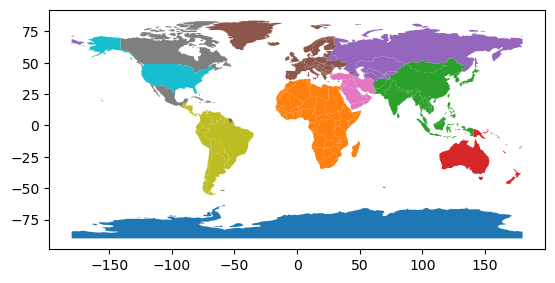

In [4]:
world.plot("EI_region")

In [5]:
EI_geometries = world.dissolve("EI_region")

In [46]:
total_tiles = 1000
num_tiles_by_region = {
    "USA": int(np.round(total_tiles * 0.34)),
    "Middle East": int(np.round(total_tiles * 0.24)),
    "Africa": int(np.round(total_tiles * 0.12)),
    "CIS": int(np.round(total_tiles * 0.10)),
    "North America wo US": int(np.round(total_tiles * 0.05)),
    "South and Central America": int(np.round(total_tiles * 0.05)),
    "Asia": int(np.round(total_tiles * 0.05)),
    "Australia": int(np.round(total_tiles * 0.025)),
    "Europe": int(np.round(total_tiles * 0.025)),
}
num_tiles_by_region

{'USA': 340,
 'Middle East': 240,
 'Africa': 120,
 'CIS': 100,
 'North America wo US': 50,
 'South and Central America': 50,
 'Asia': 50,
 'Australia': 25,
 'Europe': 25}

### Get Oil and Gas fields

In [ ]:
producing_union = # Union of all producing areas, TODO: Insert as we can't share the one we were using

<Axes: >

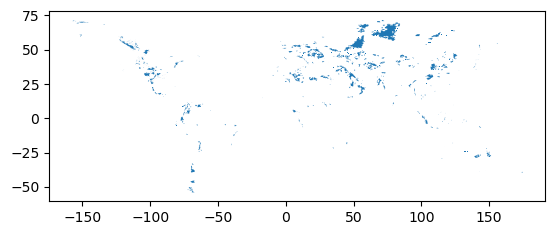

In [29]:
producing_by_region = EI_geometries.intersection(producing_union)
producing_by_region.plot()

### Get polygons for target regions (Hassi, Marcellus and Permian)

In [48]:
target_region_geoms = [
    gpd.read_file("../src/data/ancillary/hassi.geojson").geometry.iloc[0].buffer(1.8).simplify(0.1),
    gpd.read_file("../src/data/ancillary/colorado.geojson").geometry.iloc[0],
    gpd.read_file("../src/data/ancillary/permian.geojson").geometry.iloc[0],
]
target_regions = gpd.GeoDataFrame(
    {
        "region": [
            "hassi",
            "colorado",
            "permian",
        ]
    },
    geometry=target_region_geoms,
    crs="EPSG:4326",
)
target_regions.explore()

## Tile Selection Strategy

In [49]:
def clip_bbox(bbox):
    """Clip bbox to valid coordinate ranges."""
    minx, miny, maxx, maxy = bbox
    return (
        max(-180, min(180, minx)),  # longitude must be between -180 and 180
        max(-90, min(90, miny)),  # latitude must be between -90 and 90
        max(-180, min(180, maxx)),
        max(-90, min(90, maxy)),
    )


#######################################
##### SELECTING TRAINING TILES ########
#######################################


def fetch_training_items_for_region(catalog, region_geometry):
    """Fetch training items from the STAC catalog for a specific region."""
    bbox = clip_bbox(region_geometry.bounds)
    query = catalog.search(
        collections=["EMITL1BRAD_001"],
        bbox=bbox,
        datetime="2023",  # NOTE: our tiles are from 2023
        query=["eo:cloud_cover<50"],  # NOTE: training tile cloud coverage max
    )

    data = []
    for item in tqdm(query.items(), desc="Creating STAC gdf"):
        emit_id = item.id
        geometry = shape(item.geometry)
        data.append({"emit_id": emit_id, "geometry": geometry, "cloud_cover": item.properties["eo:cloud_cover"]})

    return gpd.GeoDataFrame(data, crs="EPSG:4326")


def x_intersects_any_in_y(x: gpd.GeoSeries, y: gpd.GeoSeries):
    """Checks for intersections and returns distances."""
    if len(y) == 0:
        return np.zeros(len(x), dtype=bool), np.full(len(x), np.inf)
    matches, distances = y.sindex.nearest(x, return_all=False, return_distance=True)
    return distances == 0, distances


def x_intersects_any_in_y_bool_only(x: gpd.GeoSeries, y: gpd.GeoSeries):
    """Checks for intersections and returns distances."""
    if len(y) == 0:
        return np.zeros(len(x), dtype=bool), np.full(len(x), np.inf)
    matches, distances = y.sindex.nearest(x, return_all=False, return_distance=True)
    return distances == 0


def process_region(region_name, gdf, producing_by_region, total_tiles):
    """
    Process a single region to select rows near producing areas but not intersecting.

    Parameters
    ----------
        region_name: Name of the region (e.g., 'North America', based on EI geometries)
        gdf: GeoDataFrame of pystac tiles
        producing_by_region: GeoDataFrame of producing areas
        total_tiles: Total number of tiles to select

    Returns
    -------
        GeoDataFrame of selected tiles
    """
    # Get producing areas and buffer
    producing_areas = producing_by_region.loc[[region_name]]
    tiles_intersects_producing, distances_to_producing = x_intersects_any_in_y(gdf.geometry, producing_areas.geometry)

    # Sort by distance and select top tiles
    near_tiles_sorted = gdf[tiles_intersects_producing]
    selected_tiles = near_tiles_sorted.head(total_tiles)

    return selected_tiles


#######################################
##### SELECTING VALIDATION TILES ######
#######################################


def fetch_validation_items_for_region(catalog, region_geometry, cloud_min, cloud_max):
    """Fetch validation items from the STAC catalog for a specific region."""
    bbox = clip_bbox(region_geometry.bounds)
    query = catalog.search(
        collections=["EMITL1BRAD_001"],
        bbox=bbox,
        datetime="2023",  # Validation tiles are also from 2023
        query={"eo:cloud_cover": {"gte": cloud_min, "lt": cloud_max}},
    )

    data = []
    for item in tqdm(query.items(), desc="Creating STAC gdf for validation"):
        emit_id = item.id
        geometry = shape(item.geometry)
        data.append({"emit_id": emit_id, "geometry": geometry})

    return gpd.GeoDataFrame(data, crs="EPSG:4326")


def process_validation_region(region_name, validation_gdf, training_gdf, producing_by_region, total_validation_tiles):
    """
    Process a single region to select validation tiles near producing areas but not intersecting and avoiding training tiles.

    Parameters
    ----------
        region_name: Name of the region (e.g., 'North America', based on EI geometries)
        validation_gdf: GeoDataFrame of pystac validation tiles
        training_gdf: GeoDataFrame of training tiles to exclude
        producing_by_region: GeoDataFrame of producing areas
        total_validation_tiles: Total number of validation tiles to select

    Returns
    -------
        GeoDataFrame of selected validation tiles
    """
    # Exclude items already used in training
    validation_gdf = validation_gdf[~validation_gdf["emit_id"].isin(training_gdf["emit_id"])]

    # Get producing areas and buffer
    producing_areas = producing_by_region.loc[[region_name]]
    tiles_intersects_producing, distances_to_producing = x_intersects_any_in_y(
        validation_gdf.geometry, producing_areas.geometry
    )

    validation_gdf["distance_to_producing"] = distances_to_producing

    # Exclude intersecting rows
    non_intersecting = ~tiles_intersects_producing

    # Sort by distance and select top validation tiles
    near_tiles_sorted = validation_gdf[non_intersecting].sort_values(by="distance_to_producing")
    selected_validation_tiles = near_tiles_sorted.head(total_validation_tiles)

    return selected_validation_tiles


#######################################
########## PLOTTING TILES #############
#######################################


# Plot the tiles and producing regions
def plot_region_tiles(selected_tiles, producing_region, region_name):
    """
    Plot training tiles, validation tiles, and producing regions for a region.

    Parameters
    ----------
        selected_tiles: GeoDataFrame of training tiles
        cloud_bucket_tiles: Dictionary of GeoDataFrames for cloud buckets
        producing_region: GeoDataFrame of producing regions
        region_name: Name of the region (e.g., 'North America')
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot producing regions
    producing_region.loc[[region_name]].plot(ax=ax, color="red", alpha=0.5, label="Producing Region")

    # Plot training tiles
    selected_tiles.plot(ax=ax, color="blue", alpha=0.6, label="Training Tiles")

    # Plot validation tiles for each cloud bucket
    # colors = ["green", "orange", "purple"]  # Define colors for cloud buckets
    # for i, (bucket_name, tiles) in enumerate(cloud_bucket_tiles.items()):
    #    tiles.plot(ax=ax, color=colors[i], alpha=0.6, label=f"Validation {bucket_name}")

    # Manually create legend
    legend_handles = [
        mpatches.Patch(color="red", alpha=0.5, label="Producing Region"),
        mpatches.Patch(color="blue", alpha=0.6, label="Training Tiles"),
        # mpatches.Patch(color="green", alpha=0.6, label="Validation cloud_bucket_1"),
        # mpatches.Patch(color="orange", alpha=0.6, label="Validation cloud_bucket_20"),
        # mpatches.Patch(color="purple", alpha=0.6, label="Validation cloud_bucket_50"),
    ]
    plt.legend(handles=legend_handles, loc="upper right")

    # Add labels and grid
    plt.title(f"{region_name}: Training and Validation Tiles")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


def plot_target_region_tiles(selected_tiles, target_region, region_name):
    """
    Plot training tiles, validation tiles, and producing regions for a region.

    Parameters
    ----------
        selected_tiles: GeoDataFrame of training tiles
        cloud_bucket_tiles: Dictionary of GeoDataFrames for cloud buckets
        producing_region: GeoDataFrame of producing regions
        region_name: Name of the region (e.g., 'North America')
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot producing regions
    target_region.plot(ax=ax, color="red", alpha=0.5, label="Target Region")

    # Plot training tiles
    selected_tiles.plot(ax=ax, color="blue", alpha=0.6, label="Training Tiles")

    # Plot validation tiles for each cloud bucket
    # colors = ["green", "orange", "purple"]  # Define colors for cloud buckets
    # for i, (bucket_name, tiles) in enumerate(cloud_bucket_tiles.items()):
    #    tiles.plot(ax=ax, color=colors[i], alpha=0.6, label=f"Validation {bucket_name}")

    # Manually create legend
    legend_handles = [
        mpatches.Patch(color="red", alpha=0.5, label="Producing Region"),
        mpatches.Patch(color="blue", alpha=0.6, label="Training Tiles"),
        # mpatches.Patch(color="green", alpha=0.6, label="Validation cloud_bucket_1"),
        # mpatches.Patch(color="orange", alpha=0.6, label="Validation cloud_bucket_20"),
        # mpatches.Patch(color="purple", alpha=0.6, label="Validation cloud_bucket_50"),
    ]
    plt.legend(handles=legend_handles, loc="upper right")

    # Add labels and grid
    plt.title(f"{region_name}: Training and Validation Tiles")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


def plot_target_region_tiles_training_and_validation(training_tiles, validation_tiles, target_region, region_name):
    """
    Plot training tiles, validation tiles, and producing regions for a region.

    Parameters
    ----------
        selected_tiles: GeoDataFrame of training tiles
        cloud_bucket_tiles: Dictionary of GeoDataFrames for cloud buckets
        producing_region: GeoDataFrame of producing regions
        region_name: Name of the region (e.g., 'North America')
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot producing regions
    target_region.plot(ax=ax, color="red", alpha=0.5, label="Target Region")

    # Plot training tiles
    training_tiles.plot(ax=ax, color="blue", alpha=0.6, label="Training Tiles")
    validation_tiles.plot(ax=ax, color="green", alpha=0.6, label="Validation Tiles")

    # Plot validation tiles for each cloud bucket
    # colors = ["green", "orange", "purple"]  # Define colors for cloud buckets
    # for i, (bucket_name, tiles) in enumerate(cloud_bucket_tiles.items()):
    #    tiles.plot(ax=ax, color=colors[i], alpha=0.6, label=f"Validation {bucket_name}")

    # Manually create legend
    legend_handles = [
        mpatches.Patch(color="red", alpha=0.5, label="Producing Region"),
        mpatches.Patch(color="blue", alpha=0.6, label="Training Tiles"),
        mpatches.Patch(color="green", alpha=0.6, label="Validation Tiles"),
        # mpatches.Patch(color="green", alpha=0.6, label="Validation cloud_bucket_1"),
        # mpatches.Patch(color="orange", alpha=0.6, label="Validation cloud_bucket_20"),
        # mpatches.Patch(color="purple", alpha=0.6, label="Validation cloud_bucket_50"),
    ]
    plt.legend(handles=legend_handles, loc="upper right")

    # Add labels and grid
    plt.title(f"{region_name}: Training and Validation Tiles")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

### Select tile ids in target areas

In [50]:
for region_name in target_regions["region"]:
    print(f"Number of tiles in {region_name}: {len(region_name)}")

Number of tiles in hassi: 5
Number of tiles in colorado: 8
Number of tiles in permian: 7


In [51]:
%%time

from pystac_client import Client

catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


region_names = ["hassi", "colorado", "permian"]
tiles_by_target_region = {}

for region_name in region_names:
    print(f"Gathering tiles for {region_name}")

    # Fetch items for the region
    region_geometry = target_regions.loc[target_regions["region"] == region_name, "geometry"].iloc[0]
    gdf = fetch_training_items_for_region(catalog, region_geometry)

    tiles_by_target_region[region_name] = gdf

Gathering tiles for hassi


Creating STAC gdf: 113it [00:04, 24.28it/s]


Gathering tiles for colorado


Creating STAC gdf: 151it [00:06, 22.01it/s]


Gathering tiles for permian


Creating STAC gdf: 155it [00:06, 25.61it/s]

CPU times: user 364 ms, sys: 4.44 ms, total: 368 ms
Wall time: 18.4 s


In [52]:
tiles_by_target_region["hassi"].head()

,emit_id,geometry,cloud_cover
0,EMIT_L1B_RAD_001_20230124T141848_2302410_033,"POLYGON ((7.49154 29.84301, 6.5328 28.93471, 7.07401 28.36345, 8.03275 29.27176, 7.49154 29.84301))",20
1,EMIT_L1B_RAD_001_20230127T132945_2302709_037,"POLYGON ((3.89674 31.30873, 3.21017 30.68499, 3.74161 30.10001, 4.42818 30.72375, 3.89674 31.30873))",36
2,EMIT_L1B_RAD_001_20230127T132957_2302709_038,"POLYGON ((4.49724 31.84245, 3.79999 31.21918, 4.32807 30.62842, 5.02532 31.25168, 4.49724 31.84245))",29
3,EMIT_L1B_RAD_001_20230127T133009_2302709_039,"POLYGON ((5.10747 32.37334, 4.39582 31.7498, 4.91878 31.15294, 5.63043 31.77648, 5.10747 32.37334))",40
4,EMIT_L1B_RAD_001_20230127T133021_2302709_040,"POLYGON ((5.72462 32.9001, 5.00057 32.27814, 5.51838 31.67534, 6.24243 32.2973, 5.72462 32.9001))",43


In [53]:
sum = 0
for region_name, target_tiles in tiles_by_target_region.items():
    print(f"Number of tiles in {region_name}: {len(target_tiles)}")
    sum += len(target_tiles)
print(f"Total number of tiles: {sum}")

Number of tiles in hassi: 113
Number of tiles in colorado: 151
Number of tiles in permian: 155
Total number of tiles: 419


Plotting tiles for hassi


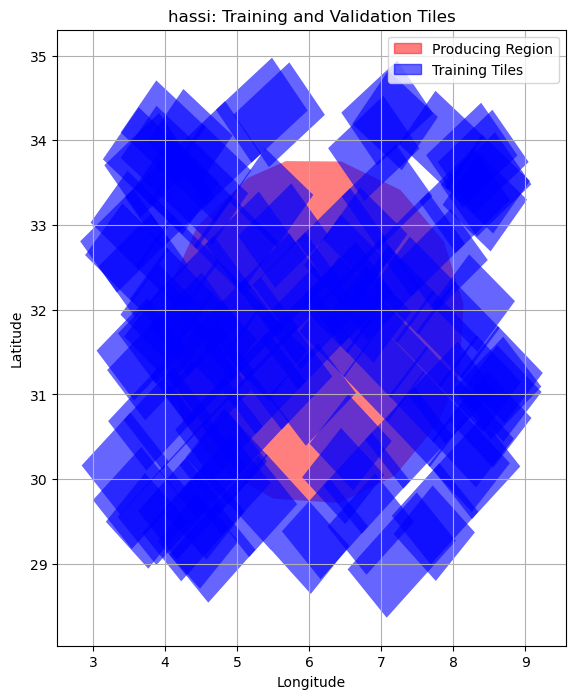

Plotting tiles for colorado


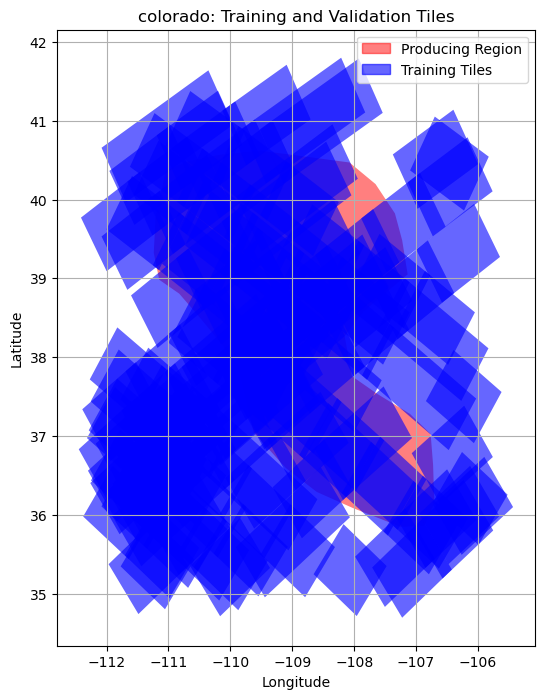

Plotting tiles for permian


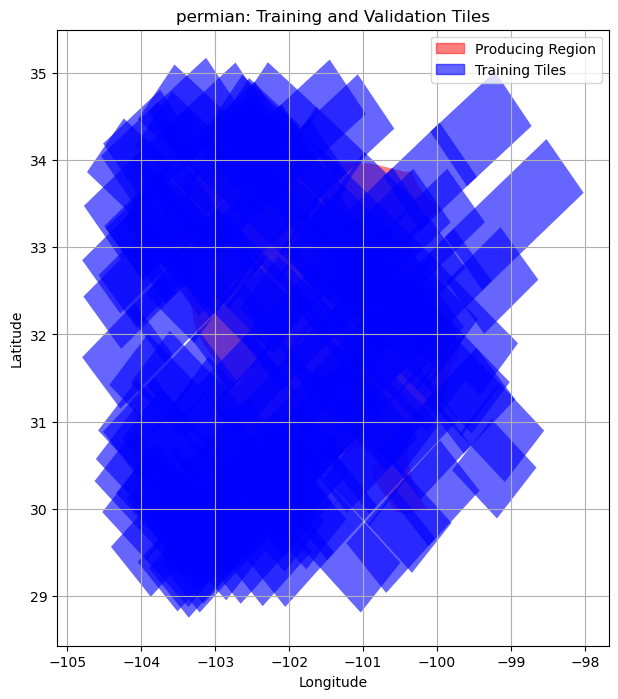

In [54]:
for region_name, training_tiles in tiles_by_target_region.items():
    print(f"Plotting tiles for {region_name}")
    target_region = target_regions[target_regions["region"] == region_name]
    plot_target_region_tiles(training_tiles, target_region, region_name)

### Split target regions into training and validation

#### K-means Clustering with 10 groups

/tmp/ipykernel_8129/372682737.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_x"] = gdf["geometry"].centroid.x
/tmp/ipykernel_8129/372682737.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_y"] = gdf["geometry"].centroid.y
/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/anaconda/envs/methane-cv-2/lib/python3.10/site

Cloud cover distribution for hassi:
Number of tiles in training: 57
Number of tiles in validation: 56
Training summary: 
 count    57.000000
mean     22.666667
std      14.878476
min       0.000000
25%       9.000000
50%      22.000000
75%      36.000000
max      50.000000
Name: cloud_cover, dtype: float64
Validation summary: 
 count    56.000000
mean     22.928571
std      16.107432
min       0.000000
25%       7.750000
50%      23.500000
75%      36.250000
max      50.000000
Name: cloud_cover, dtype: float64


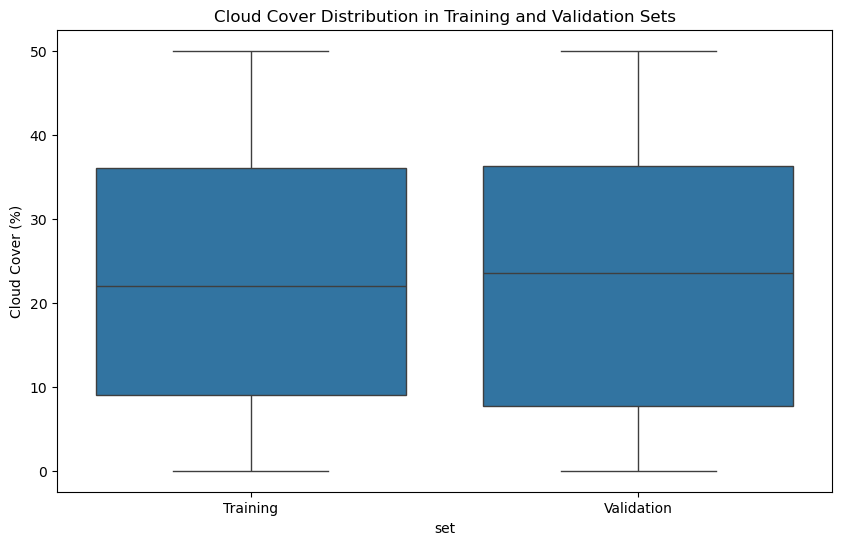

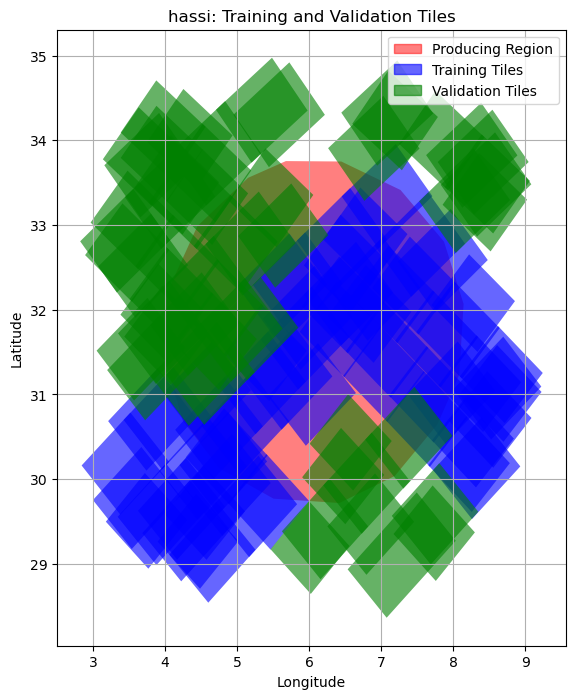

/tmp/ipykernel_8129/372682737.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_x"] = gdf["geometry"].centroid.x
/tmp/ipykernel_8129/372682737.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_y"] = gdf["geometry"].centroid.y
/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/anaconda/envs/methane-cv-2/lib/python3.10/site

Cloud cover distribution for colorado:
Number of tiles in training: 76
Number of tiles in validation: 75
Training summary: 
 count    76.000000
mean     15.157895
std      16.180690
min       0.000000
25%       3.750000
50%       7.500000
75%      22.250000
max      50.000000
Name: cloud_cover, dtype: float64
Validation summary: 
 count    75.000000
mean     15.066667
std      15.044379
min       0.000000
25%       2.500000
50%       9.000000
75%      24.500000
max      50.000000
Name: cloud_cover, dtype: float64


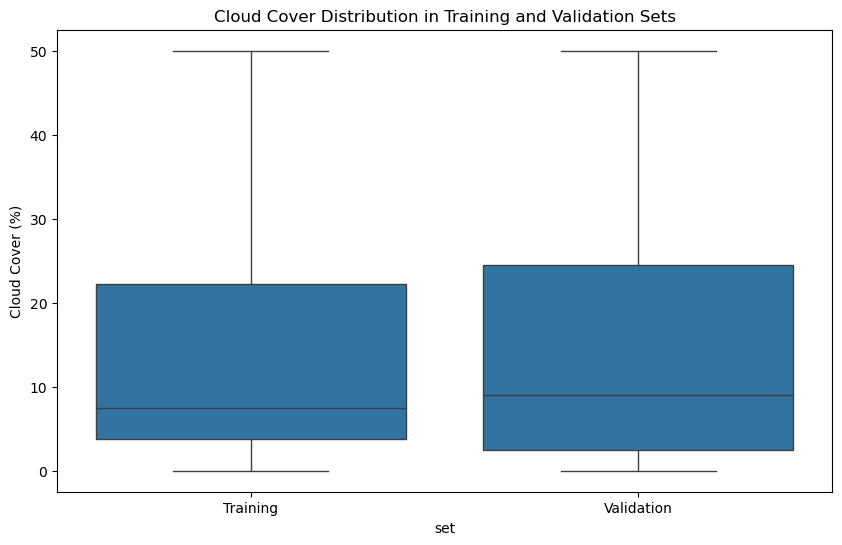

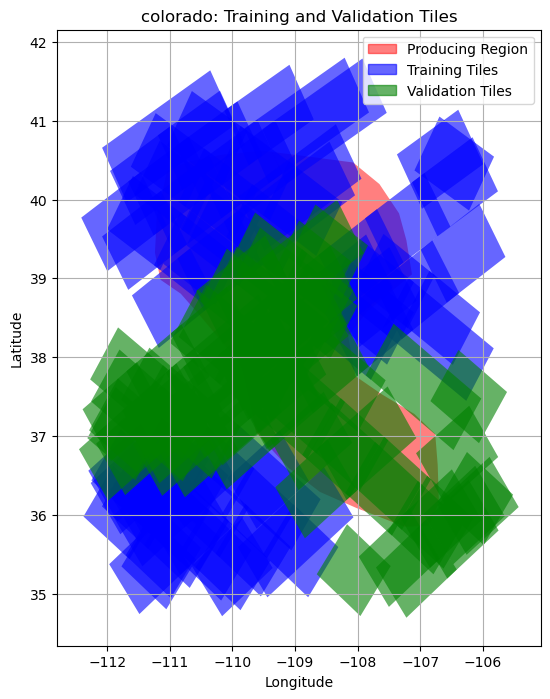

/tmp/ipykernel_8129/372682737.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_x"] = gdf["geometry"].centroid.x
/tmp/ipykernel_8129/372682737.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_y"] = gdf["geometry"].centroid.y
/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/anaconda/envs/methane-cv-2/lib/python3.10/site

Cloud cover distribution for permian:
Number of tiles in training: 87
Number of tiles in validation: 68
Training summary: 
 count    87.000000
mean     16.206897
std      14.725502
min       0.000000
25%       5.000000
50%      10.000000
75%      29.000000
max      50.000000
Name: cloud_cover, dtype: float64
Validation summary: 
 count    68.000000
mean     12.588235
std      13.169657
min       0.000000
25%       2.000000
50%       7.500000
75%      21.000000
max      49.000000
Name: cloud_cover, dtype: float64


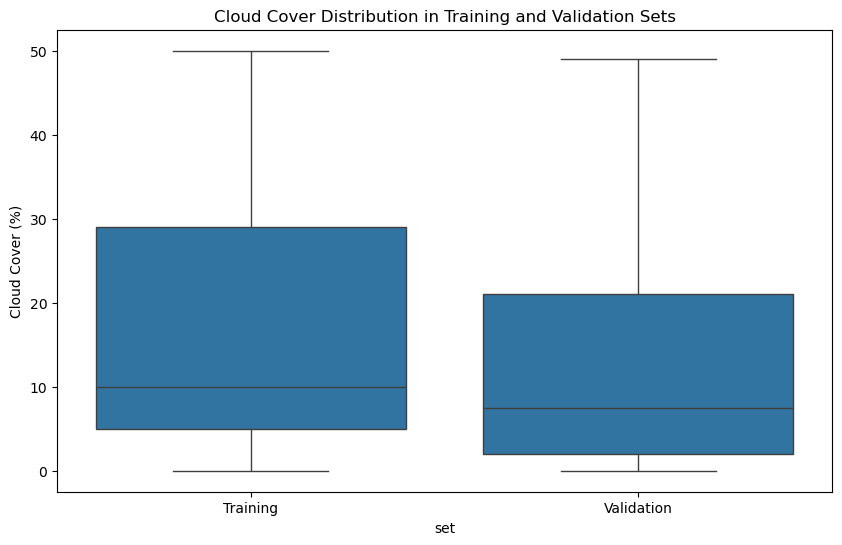

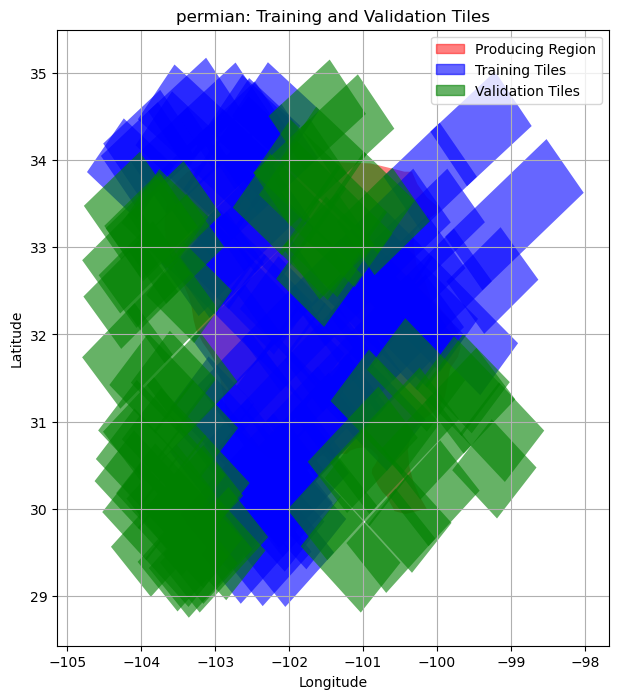

In [55]:
# Function to calculate overlap percentage
train = pd.DataFrame()
val = pd.DataFrame()


def calculate_overlap(row):
    if row["geometry"].intersects(validation_geom):
        intersection = row["geometry"].intersection(validation_geom)
        overlap_percent = intersection.area / row["geometry"].area
        return overlap_percent
    else:
        return 0


region_names = [["hassi", 0.5], ["colorado", 0.5], ["permian", 0.5]]

for region_name, _overlap_threshold in region_names:
    gdf = tiles_by_target_region[region_name].sort_values(by="cloud_cover")
    gdf["centroid_x"] = gdf["geometry"].centroid.x
    gdf["centroid_y"] = gdf["geometry"].centroid.y

    kmeans = KMeans(n_clusters=10, random_state=42)
    gdf["cluster"] = kmeans.fit_predict(gdf[["centroid_x", "centroid_y"]])

    # Step 2: Split clusters into train and validation sets
    # Randomly sample half the clusters for training, the rest for validation
    clusters = np.unique(gdf["cluster"])
    np.random.seed(42)
    train_clusters = np.random.choice(clusters, size=5, replace=False)
    val_clusters = np.setdiff1d(clusters, train_clusters)

    train_zone = gdf[gdf["cluster"].isin(train_clusters)]
    val_zone = gdf[gdf["cluster"].isin(val_clusters)]

    ## Step 3: Remove overlaps from training set
    # validation_geom = unary_union(val_zone["geometry"])
    # train_zone["overlap_percent"] = train_zone.apply(calculate_overlap, axis=1)

    # Drop tiles with more than 20% overlap
    # overlap_tiles = train_zone[train_zone["overlap_percent"] > overlap_threshold]
    # overlap_tiles = overlap_tiles.drop(columns=["overlap_percent"])
    # train_zone = train_zone[train_zone["overlap_percent"] <= overlap_threshold]
    # train_zone = train_zone.drop(columns=["overlap_percent"])
    # val_zone = gpd.GeoDataFrame(pd.concat([val_zone, overlap_tiles], ignore_index=True))

    train_zone["region"] = region_name
    val_zone["region"] = region_name

    # Step 4: Cap training and validation sets at 50 tiles each (if needed)
    # if len(train_zone) > 50:
    # train_zone = train_zone.sample(n=50, random_state=42)

    # if len(val_zone) > 50:
    # val_zone = val_zone.sample(n=50, random_state=42)

    train = pd.concat([train, train_zone], ignore_index=True)
    val = pd.concat([val, val_zone], ignore_index=True)

    train_cloud = train_zone["cloud_cover"].mean()
    val_cloud = val_zone["cloud_cover"].mean()

    # 5-number summary for cloud cover in training and validation sets
    train_summary = train_zone["cloud_cover"].describe()
    val_summary = val_zone["cloud_cover"].describe()

    print(f"Cloud cover distribution for {region_name}:")
    print(f"Number of tiles in training: {len(train_zone)}")
    print(f"Number of tiles in validation: {len(val_zone)}")
    print(f"Training summary: \n {train_summary}")
    print(f"Validation summary: \n {val_summary}")

    # Create long-format DataFrame for boxplot
    train_zone["set"] = "Training"
    val_zone["set"] = "Validation"
    combined = pd.concat([train_zone, val_zone])

    # Create boxplots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="set", y="cloud_cover", data=combined)
    plt.title("Cloud Cover Distribution in Training and Validation Sets")
    plt.ylabel("Cloud Cover (%)")
    plt.show()

    target_region = target_regions[target_regions["region"] == region_name]
    plot_target_region_tiles_training_and_validation(train_zone, val_zone, target_region, region_name)

In [56]:
print(len(train))
print(len(val))

220
199


### Select other non-target regions

In [57]:
%%time

catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


regions = [
    "USA",
    "North America wo US",
    "Europe",
    "CIS",
    "Middle East",
    "Asia",
    "Africa",
    "South and Central America",
    "Australia",
]
tiles_by_region = {}

for region_name in regions:
    print(f"Gathering tiles for {region_name}")

    # Fetch items for the region
    region_geometry = EI_geometries.loc[region_name].geometry
    gdf = fetch_training_items_for_region(catalog, region_geometry)

    # Process the region to select tiles
    selected_tiles = process_region(region_name, gdf, producing_by_region, num_tiles_by_region[region_name])

    tiles_by_region[region_name] = selected_tiles

    # Define cloud buckets
    # cloud_buckets = {"cloud_bucket_1": (0, 1), "cloud_bucket_20": (1, 20), "cloud_bucket_50": (20, 50)}

    # cloud_bucket_tiles = {}

    # # Iterate through each cloud bucket
    # for bucket_name, (cloud_min, cloud_max) in cloud_buckets.items():
    #     print(f"Processing {bucket_name}...")

    #     # Fetch items for the region
    #     validation_gdf = fetch_validation_items_for_region(catalog, region_geometry, cloud_min, cloud_max)

    #     # Process the region to select validation tiles
    #     selected_validation_tiles = process_validation_region(
    #         region_name,
    #         validation_gdf,
    #         selected_tiles,
    #         producing_by_region,
    #         num_validation_tiles_per_cloud_bucket_by_region[region_name],
    #     )
    #     cloud_bucket_tiles[bucket_name] = selected_validation_tiles

    # validation_tiles_by_region[region_name] = cloud_bucket_tiles

Gathering tiles for USA


Creating STAC gdf: 2660it [01:49, 24.23it/s]


Gathering tiles for North America wo US


Creating STAC gdf: 2660it [02:06, 20.98it/s]


Gathering tiles for Europe


Creating STAC gdf: 15323it [13:53, 18.38it/s]


Gathering tiles for CIS


Creating STAC gdf: 7420it [05:45, 21.50it/s]


Gathering tiles for Middle East


Creating STAC gdf: 6038it [04:39, 21.58it/s]


Gathering tiles for Asia


Creating STAC gdf: 11663it [09:54, 19.61it/s]


Gathering tiles for Africa


Creating STAC gdf: 13643it [13:37, 16.68it/s]


Gathering tiles for South and Central America


Creating STAC gdf: 1815it [01:40, 18.11it/s]


Gathering tiles for Australia


Creating STAC gdf: 5158it [03:36, 23.84it/s]

CPU times: user 57.7 s, sys: 2.41 s, total: 1min
Wall time: 57min 9s


In [62]:
sum = 0
for region_name, training_tiles in tiles_by_region.items():
    print(f"Number of tiles in {region_name}: {len(training_tiles)}")
    sum += len(training_tiles)
print(f"Total number of tiles: {sum}")

Number of tiles in USA: 340
Number of tiles in North America wo US: 32
Number of tiles in Europe: 25
Number of tiles in CIS: 100
Number of tiles in Middle East: 240
Number of tiles in Asia: 50
Number of tiles in Africa: 120
Number of tiles in South and Central America: 50
Number of tiles in Australia: 25
Total number of tiles: 982


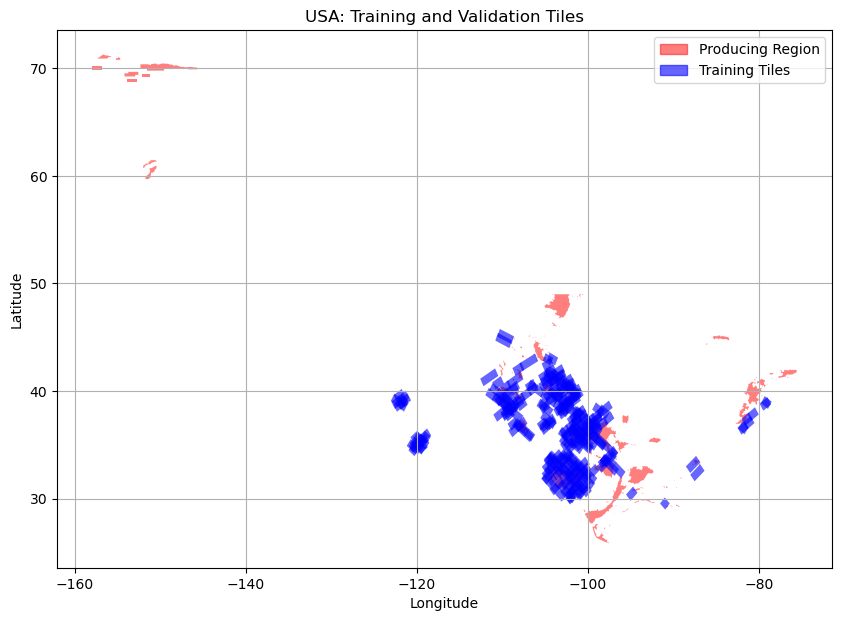

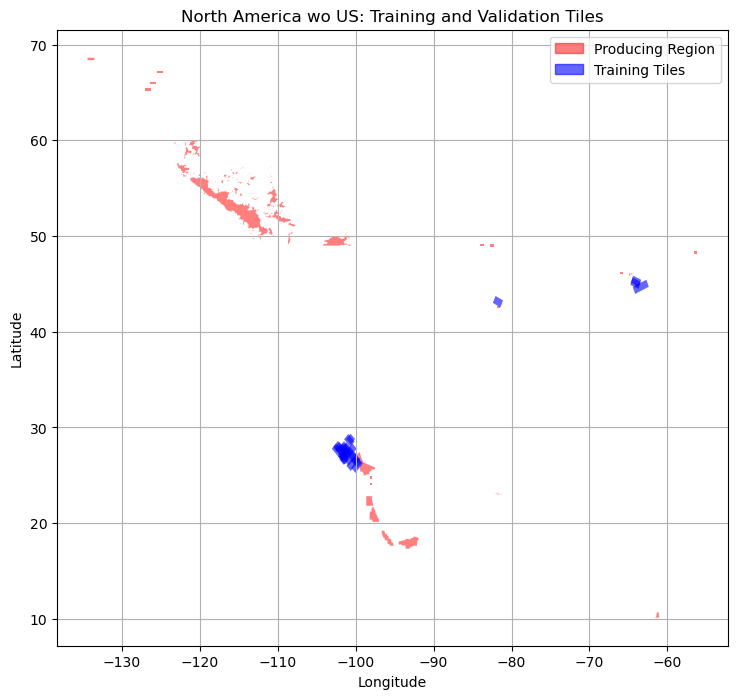

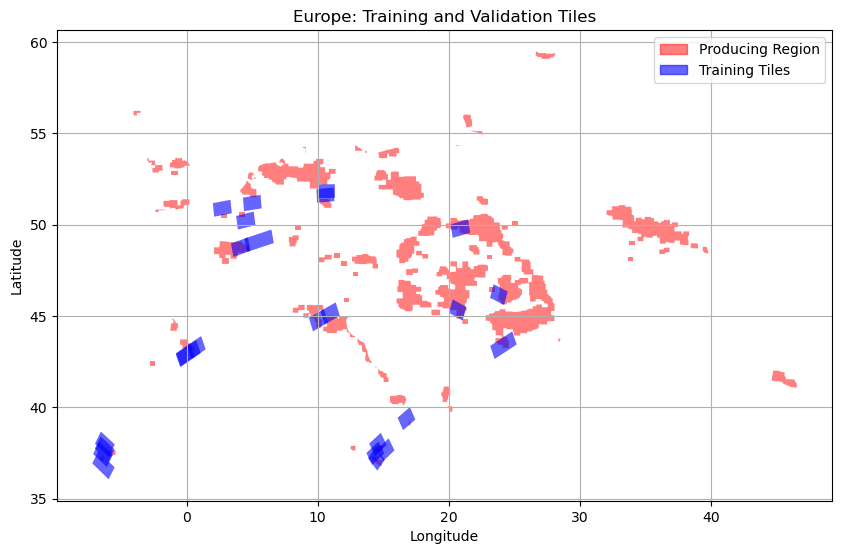

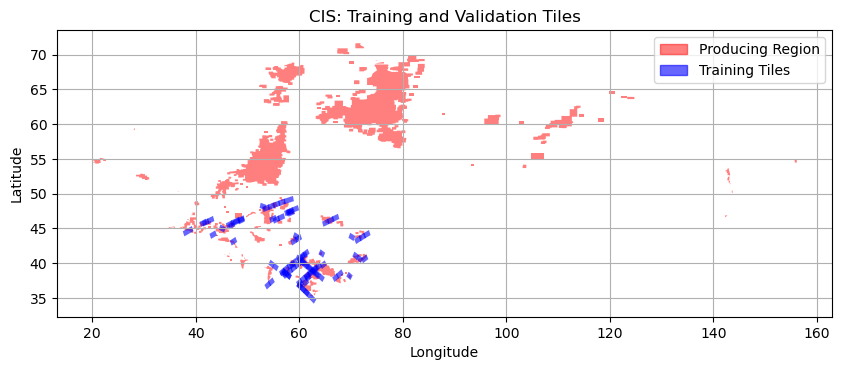

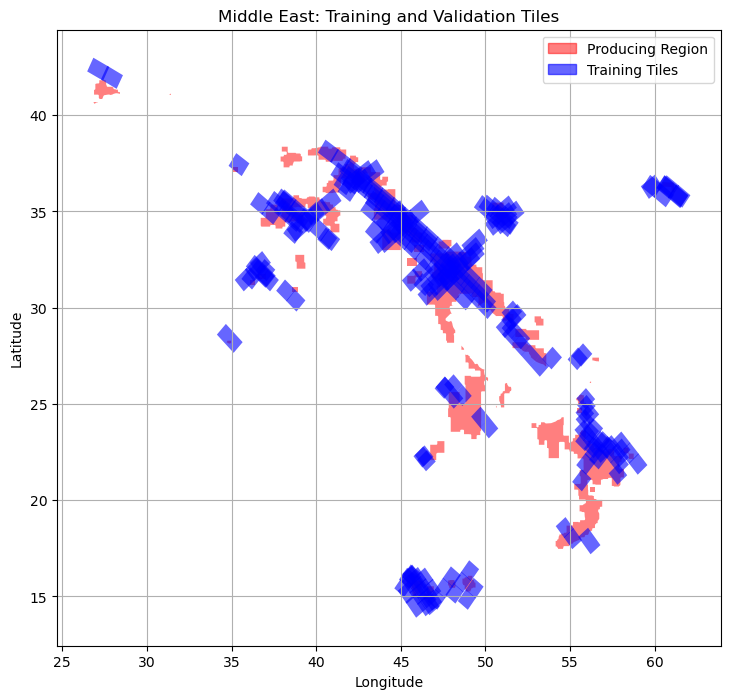

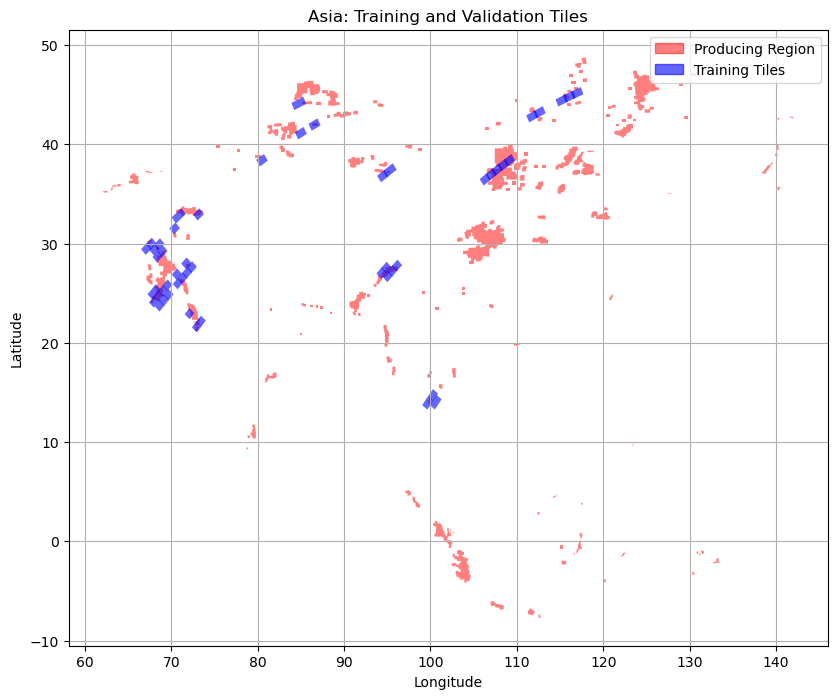

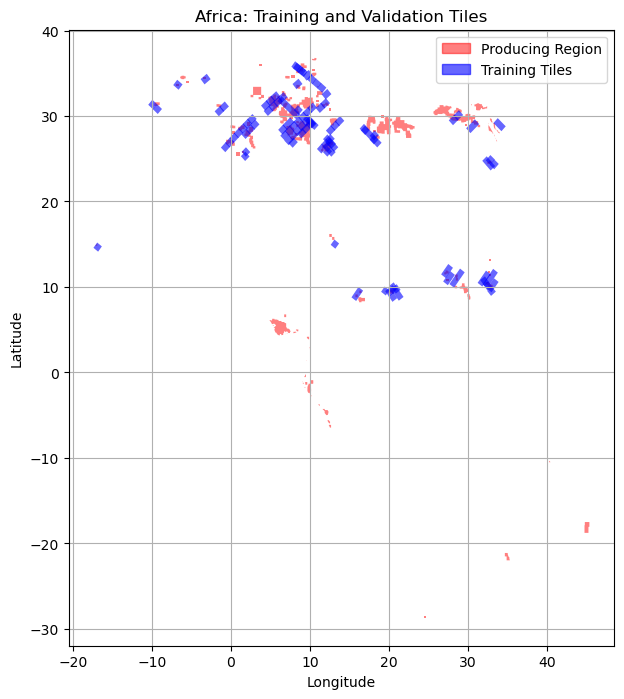

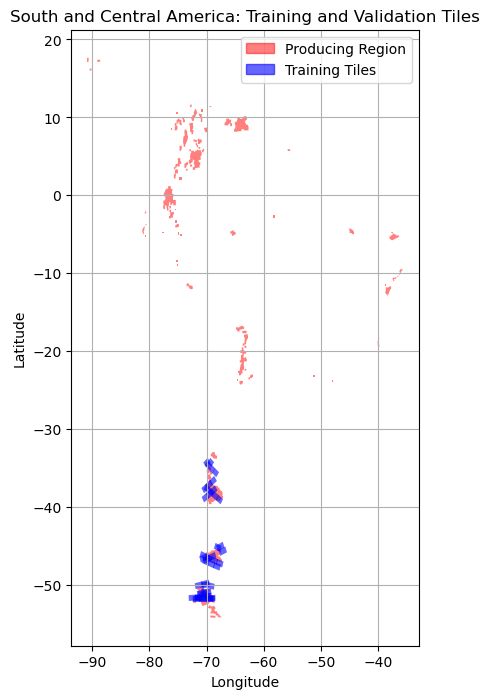

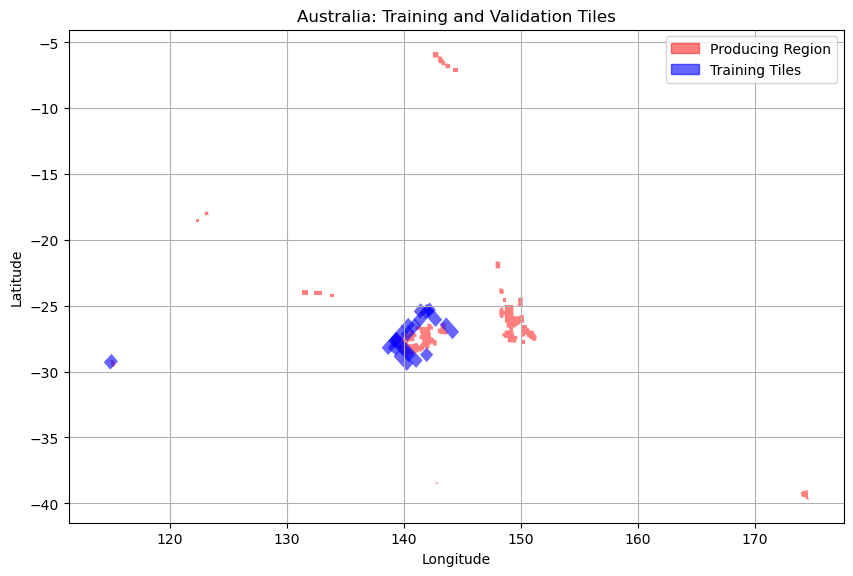

In [63]:
for region_name, training_tiles in tiles_by_region.items():
    plot_region_tiles(training_tiles, producing_by_region, region_name)

### Merge dicst into val and train GDFs



In [64]:
train_df = pd.DataFrame(train)
val_df = pd.DataFrame(val)

for region_name, training_tiles in tiles_by_region.items():
    training_tiles["region"] = region_name
    train_df = pd.concat([train_df, training_tiles], ignore_index=True)

train_df = train_df.drop_duplicates(subset="emit_id", keep="first")

print(len(train_df))
print(len(val_df))

1120
199


In [66]:
# Merge selected tiles into training set
train_df["fold"] = "train"
val_df["fold"] = "val"

train_df.to_csv("../src/data/tiles/emit/csv_files/2025_03_21_MGRS_with_IDs_within_OG_4547_train_1120.csv", index=False)
val_df.to_csv("../src/data/tiles/emit/csv_files/2025_03_21_MGRS_with_IDs_within_OG_4547_val_199.csv", index=False)

selected_tiles_df = pd.concat((train_df, val_df), ignore_index=True)

# Save the GeoDataFrame to a GeoJSON file
selected_tiles_gdf = gpd.GeoDataFrame(selected_tiles_df, geometry="geometry")
output_path = "../src/data/tiles/emit/csv_files/2025_03_21_MGRS_with_IDs_within_OG_4547_with_metadata.geojson"
selected_tiles_gdf.to_file(output_path, driver="GeoJSON")

## Look at global EMIT data availability

In [5]:
# get country boundaries
#!curl -L -o data/ne_110m_admin_0_countries.zip https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
#!unzip -u data/ne_110m_admin_0_countries.zip -d data/ne_110m_admin_0_countries
#!rm data/ne_110m_admin_0_countries.zip

# now we're going to map countries in the world dataframeto the EI regions
# This won't be pretty.
# Note: moved Turkey from Europe to Middle East
world = gpd.read_file("data/ne_110m_admin_0_countries/")
world.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)

In [6]:
EI_countries_in_regions = {  # copy-pasted from spreadsheet
    "USA": ["United States of America"],
    "North America wo US": ["Canada", "Mexico"],
    "Europe": [
        "Denmark",
        "Germany",
        "Italy",
        "Netherlands",
        "Norway",
        "Poland",
        "Romania",
        "Ukraine",
        "United Kingdom",
        "Georgia",
    ],
    "CIS": [
        "Armenia",
        "Azerbaijan",
        "Belarus",
        "Kazakhstan",
        "Kyrgyzstan",
        "Moldova",
        "Russia",
        "Tajikistan",
        "Turkmenistan",
        "Uzbekistan",
    ],
    "Middle East": [
        "Bahrain",
        "Iran",
        "Iraq",
        "Israel",
        "Kuwait",
        "Oman",
        "Qatar",
        "Saudi Arabia",
        "Syria",
        "United Arab Emirates",
        "Jordan",
        "Lebanon",
        "Turkey",
    ],
    "Asia": [
        "Bangladesh",
        "Brunei",
        "China",
        "India",
        "Indonesia",
        "Malaysia",
        "Myanmar",
        "Pakistan",
        "Thailand",
        "Vietnam",
    ],
}

world["EI_region"] = world["CONTINENT"].map(
    {
        "Africa": "Africa",
        "Asia": "Asia",
        "Europe": "Europe",
        "North America": "North America wo US",
        "South America": "South and Central America",
        "Oceania": "Australia",
        "Seven seas (open ocean)": "",
        "Antarctica": "",
    }
)

world.loc[world["SUBREGION"] == "Central America", "EI_region"] = "South and Central America"
world.loc[world["REGION_WB"] == "Middle East & North Africa", "EI_region"] = "Middle East"
world.loc[world["CONTINENT"] == "Africa", "EI_region"] = "Africa"
world.loc[world["SUBREGION"] == "Australia and New Zealand", "EI_region"] = "Australia"

EI_country_to_region_map = {
    country: region for (region, country_list) in EI_countries_in_regions.items() for country in country_list
}
# check all EI countries are present in the world dataframe
world_countries_set = set(world.SOVEREIGNT)
for country in EI_country_to_region_map:
    if country == "Bahrain":
        # Bahrain is missing but it's tiny,
        # so let's ignore that
        continue
    world_countries_set.remove(country)  # this raises a KeyError if not present
EI_mapped_countries = world.SOVEREIGNT.map(EI_country_to_region_map)
world["EI_region"] = world.EI_region.where(EI_mapped_countries.isnull(), EI_mapped_countries)

world.EI_region.value_counts()

EI_region
Africa                       51
Europe                       39
Asia                         25
South and Central America    19
Middle East                  14
CIS                          10
North America wo US           8
Australia                     7
USA                           2
                              2
Name: count, dtype: int64

<Axes: >

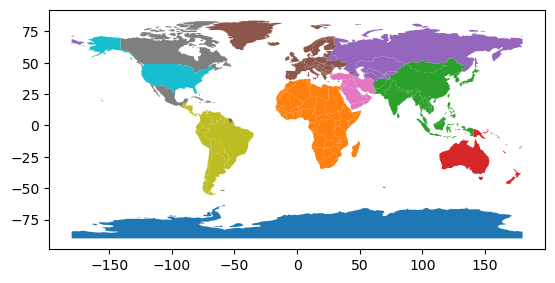

In [7]:
world.plot("EI_region")

In [10]:
%%time

catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


regions = [
    "USA",
    "North America wo US",
    "Europe",
    "CIS",
    "Middle East",
    "Asia",
    "Africa",
    "South and Central America",
    "Australia",
]
all_tiles_by_region = {}

for region_name in regions:
    print(f"Gathering tiles for {region_name}")

    # Fetch items for the region
    region_geometry = EI_geometries.loc[region_name].geometry
    gdf = fetch_training_items_for_region(catalog, region_geometry)

    all_tiles_by_region[region_name] = gdf

Gathering tiles for USA


Creating STAC gdf: 2660it [02:00, 22.09it/s]


Gathering tiles for North America wo US


Creating STAC gdf: 2660it [01:51, 23.92it/s]


Gathering tiles for Europe


Creating STAC gdf: 15323it [12:52, 19.83it/s]


Gathering tiles for CIS


Creating STAC gdf: 7420it [07:33, 16.36it/s]


Gathering tiles for Middle East


Creating STAC gdf: 6038it [04:44, 21.22it/s]


Gathering tiles for Asia


Creating STAC gdf: 11663it [10:19, 18.84it/s]


Gathering tiles for Africa


Creating STAC gdf: 13643it [10:13, 22.24it/s]


Gathering tiles for South and Central America


Creating STAC gdf: 1815it [01:22, 22.02it/s]


Gathering tiles for Australia


Creating STAC gdf: 5158it [03:52, 22.20it/s]

CPU times: user 52.4 s, sys: 2.75 s, total: 55.1 s
Wall time: 54min 51s


In [33]:
for region_name, training_tiles in all_tiles_by_region.items():
    print(f"Number of tiles in {region_name}: {len(training_tiles)}")

Number of tiles in USA: 2660
Number of tiles in North America wo US: 2660
Number of tiles in Europe: 15323
Number of tiles in CIS: 7420
Number of tiles in Middle East: 6038
Number of tiles in Asia: 11663
Number of tiles in Africa: 13643
Number of tiles in South and Central America: 1815
Number of tiles in Australia: 5158
Number of tiles in region: 6


In [30]:
all_tiles_by_region_df = pd.DataFrame(all_tiles_by_region["USA"])

for region_name, training_tiles in all_tiles_by_region.items():
    if region_name == "USA":
        continue
    all_tiles_by_region["region"] = region_name
    if type(training_tiles) == str:
        continue
    all_tiles_by_region_df = pd.concat([all_tiles_by_region_df, training_tiles], ignore_index=True)

all_tiles_by_region_gdf = gpd.GeoDataFrame(all_tiles_by_region_df, geometry="geometry")

In [31]:
output_path = "/home/azureuser/orbio/methane-cv/notebooks/data/EMIT_tiles_by_region.geojson"
all_tiles_by_region_gdf.to_file(output_path, driver="GeoJSON")

<Axes: >

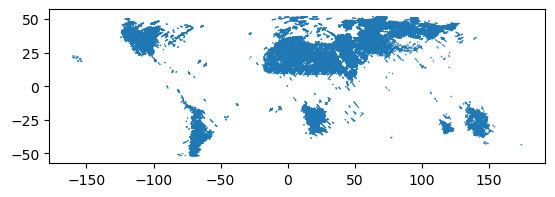

In [32]:
all_tiles_by_region_gdf.plot()